 ## Comprobación de supuestos

En la literatura se especifica que los trastornos mentales pueden llevar a alteraciones en la forma de interactuar y comunicarse. Por lo tanto, se realiza una comprobación para determinar qué hipótesis se mantienen en nuestro dataset. Estos supuestos son:

**1. Uso de pronombres en singular**
- Métrica: Análisis del uso de pronombres personales singulares.
- Ejemplo: El uso elevado de pronombres en singular indica una fijacion del individuo por si mismo el cual es un sesgo cognitivo asociado a trastornos mentales como la depresion.

**2. Longitud de Oraciones y de Palabras**

- Métrica: Promedio de palabras por oración, y longitud media de las palabras.
- Ejemplo: Un análisis podría revelar que los textos escritos por personas con depresión contienen oraciones más cortas, lo que podría indicar dificultades de concentración o un estado mental abrumado.

**3. Diversidad Léxica**
- Métrica: Relación tipo/token (TTR, por sus siglas en inglés), que mide la proporción de palabras únicas sobre el total de palabras.
- Ejemplo: Una TTR más baja en los textos de individuos con trastornos mentales podría sugerir un rango limitado de vocabulario que se usa repetidamente, lo cual puede ser indicativo de pensamientos obsesivos o limitados.

**4. Sintaxis y Estructura Gramatical**
- Métrica: Uso de diferentes partes del habla, como adverbios, adjetivos y sustantivos; complejidad de las estructuras gramaticales.
- Ejemplo: Puedes utilizar herramientas como SpaCy para analizar la estructura gramatical de las oraciones. Los resultados podrían mostrar un uso reducido de adjetivos y adverbios en individuos con depresión, lo cual podría reflejar una disminución en la expresividad emocional.

**5. Frecuencia de Construcciones Pasivas**
- Métrica: Conteo y análisis de frases en voz pasiva.
- Ejemplo: Un uso aumentado de la voz pasiva podría indicar una tendencia a describir eventos o situaciones donde el sujeto se siente afectado por acciones externas más que ser un agente activo, lo cual es común en narrativas de personas que experimentan sentimientos de impotencia o desesperanza.

In [1]:
#importacion de librerias
import spacy 
import pandas as pd
import os 
from pathlib import Path
import utils
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from sklearn.model_selection import train_test_split




In [2]:
#carga de datos 
data_path = Path(os.getcwd()).parent / "data"
train_path = data_path / "bronze" / "dreaddit-train.csv"
test_path = data_path / "bronze" / "dreaddit-test.csv"

train = pd.read_csv(train_path, usecols=['text', 'id', 'label'])
test =  pd.read_csv(test_path, usecols=['text', 'id', 'label'])
df = pd.concat([train,test]).reset_index(drop=True)
df["text"] = df["text"].str.lower()

In [3]:
print(f"Hay {df.shape[0]} registros en el dataset")

Hay 3553 registros en el dataset


In [4]:
#TODO: mejorar la limpieza de los datos y sacar el rango de tokens usados en general

In [5]:
# Cargar el modelo de SpaCy
nlp = spacy.load('en_core_web_sm')

In [6]:
#Se eliminan los carateres especiales
df["clean_text"]= df["text"].apply(utils.clean_text)
#Se eliminan los carateres especiales pero se mantienen los que son cruciales para indicar la separacion de oraciones.
df["clean_text_sentence_sep"]= df["text"].apply(utils.clean_text,keep="sen", remove_words =True)

# se almacenan todos los textos en una lista
texts = df['clean_text'].tolist()

# se almacenan todos los textos en una lista
texts_sentence_sep = df['clean_text_sentence_sep'].tolist()

#### **Frecuencia de pronombres en singular**

In [7]:
# Procesar los textos en lotes
docs = nlp.pipe(texts)

#Calculo de la longitud promedio de palabras
df["singular_pronouns"]  = [utils.calculate_pronoun_frequency(doc) for doc in docs]

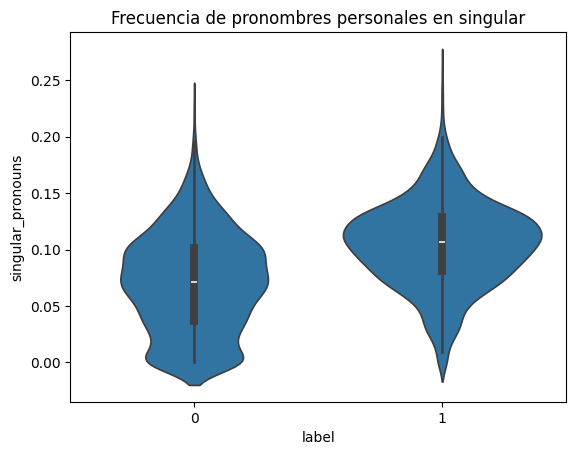

In [8]:
# Visualización de las distribuciones
ax= sns.violinplot(x='label', y='singular_pronouns', data=df)
ax.set_title('Frecuencia de pronombres personales en singular');

In [9]:
# Test de Shapiro-Wilk para normalidad
stat, p = shapiro(df[df['label'] == 0]['singular_pronouns'])
print('Grupo No Estresado - estadísticas= %.3f, p=%.3f' % (stat, p))

stat, p = shapiro(df[df['label'] == 1]['singular_pronouns'])
print('Grupo Estresado - estadísticas= %.3f, p=%.3f' % (stat, p))

Grupo No Estresado - estadísticas= 0.976, p=0.000
Grupo Estresado - estadísticas= 0.995, p=0.000


In [10]:
u_stat, p_val = mannwhitneyu(df[df['label'] == 1]['singular_pronouns'],
                             df[df['label'] == 0]['singular_pronouns'], alternative="greater")
print('Palabras: U=%.3f, p=%.3f' % (u_stat, p_val))

Palabras: U=2268563.000, p=0.000


#### **Longitud de oraciones y de palabras**

In [11]:
# Procesar los textos en lotes
docs = nlp.pipe(texts)

#Calculo de la longitud promedio de palabras
df["avg_word_len"]  = [utils.avg_word_length(doc) for doc in docs]

In [12]:
# Procesar los textos en lotes
docs = nlp.pipe(texts_sentence_sep)

#Calculo de la longitud promedio de oraciones
df["avg_sentence_len"] = [utils.avg_sentence_length(doc) for doc in docs]

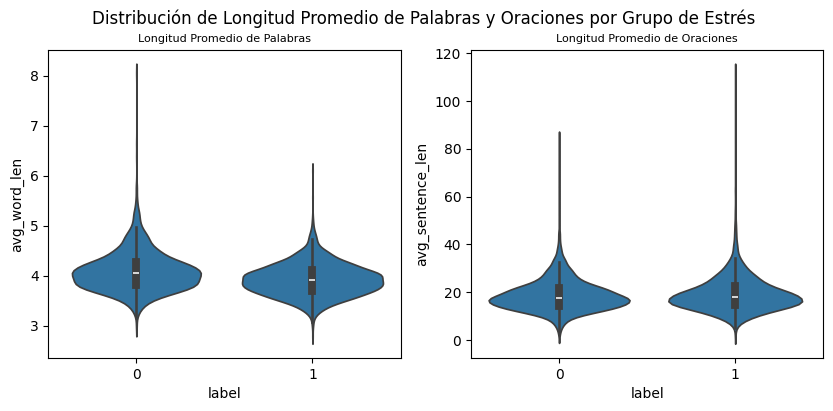

In [13]:
# Visualización de las distribuciones
fig, axes = plt.subplots(1,2, figsize=(10,4))

fig.suptitle('Distribución de Longitud Promedio de Palabras y Oraciones por Grupo de Estrés')

ax1= sns.violinplot(x='label', y='avg_word_len', data=df, ax=axes[0])
ax1.set_title('Longitud Promedio de Palabras', size=8)

ax2 = sns.violinplot(x='label', y='avg_sentence_len', data=df, ax=axes[1])
ax2.set_title('Longitud Promedio de Oraciones', size=8);

In [14]:
# Test de Shapiro-Wilk para normalidad
stat, p = shapiro(df[df['label'] == 0]['avg_word_len'])
print('Grupo No Estresado (Palabras) - estadísticas= %.3f, p=%.3f' % (stat, p))

stat, p = shapiro(df[df['label'] == 1]['avg_word_len'])
print('Grupo Estresado (Palabras) - estadísticas= %.3f, p=%.3f' % (stat, p))

stat, p = shapiro(df[df['label'] == 0]['avg_sentence_len'])
print('Grupo No Estresado (Oraciones) - estadísticas= %.3f, p=%.3f' % (stat, p))

stat, p = shapiro(df[df['label'] == 1]['avg_sentence_len'])
print('Grupo Estresado (Oraciones) - estadísticas= %.3f, p=%.3f' % (stat, p))

Grupo No Estresado (Palabras) - estadísticas= 0.928, p=0.000
Grupo Estresado (Palabras) - estadísticas= 0.984, p=0.000
Grupo No Estresado (Oraciones) - estadísticas= 0.886, p=0.000
Grupo Estresado (Oraciones) - estadísticas= 0.818, p=0.000


In [15]:
# Prueba U de Mann-Whitney
u_stat, p_val = mannwhitneyu(df[df['label'] == 0]['avg_word_len'],
                             df[df['label'] == 1]['avg_word_len'])
print('Palabras: U=%.3f, p=%.3f' % (u_stat, p_val))

u_stat, p_val = mannwhitneyu(df[df['label'] == 0]['avg_sentence_len'],
                             df[df['label'] == 1]['avg_sentence_len'])
print('Oraciones: U=%.3f, p=%.3f' % (u_stat, p_val))


Palabras: U=1949761.000, p=0.000
Oraciones: U=1522780.000, p=0.089


In [16]:
u_stat, p_val = mannwhitneyu(df[df['label'] == 1]['avg_word_len'],
                             df[df['label'] == 0]['avg_word_len'], alternative="less")
print('Palabras: U=%.3f, p=%.3f' % (u_stat, p_val))

u_stat, p_val = mannwhitneyu(df[df['label'] == 1]['avg_sentence_len'],
                             df[df['label'] == 0]['avg_sentence_len'], alternative="less")
print('Palabras: U=%.3f, p=%.3f' % (u_stat, p_val))


Palabras: U=1199711.000, p=0.000
Palabras: U=1626692.000, p=0.956


En esta sección, se llevó a cabo una comparación entre la longitud promedio de palabras y oraciones de individuos estresados y no estresados para determinar si existen diferencias significativas en el léxico utilizado por estos dos grupos. Los resultados indican que las distribuciones de los datos no son normales, lo cual justificó el uso de pruebas no paramétricas para el análisis estadístico.

A través de estas pruebas, se identificó una diferencia estadísticamente significativa en la longitud promedio de palabras entre el grupo estresado y el grupo no estresado, sugiriendo que las personas estresadas tienden a utilizar palabras más cortas en comparación con aquellas que no están estresadas. Sin embargo, no se observaron diferencias significativas en la longitud promedio de las oraciones entre ambos grupos.

Estos hallazgos sugieren que, aunque la estructura de las oraciones no varía significativamente con el estado de estrés, el uso de palabras más cortas podría reflejar un impacto del estrés en la selección léxica de los individuos. 

#### **Diversidad Léxica**

In [17]:
# Procesar los textos en lotes
docs = nlp.pipe(texts)

#Calculo de la diversidad lexica
df["lex_diversity"]  = [utils.lexical_diversity(doc) for doc in docs]

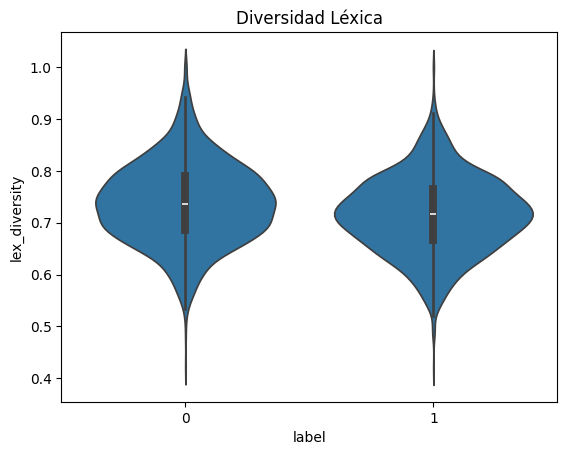

In [18]:
# Visualización de las distribuciones
ax= sns.violinplot(x='label', y='lex_diversity', data=df)
ax.set_title('Diversidad Léxica');


In [19]:
# Test de Shapiro-Wilk para normalidad
stat, p = shapiro(df[df['label'] == 0]['lex_diversity'])
print('Grupo No Estresado - estadísticas= %.3f, p=%.3f' % (stat, p))

stat, p = shapiro(df[df['label'] == 1]['lex_diversity'])
print('Grupo Estresado - estadísticas= %.3f, p=%.3f' % (stat, p))

Grupo No Estresado - estadísticas= 0.998, p=0.027
Grupo Estresado - estadísticas= 0.999, p=0.411


In [20]:
from scipy.stats import levene

# Prueba de Levene para igualdad de varianzas
stat, p = levene(df[df['label'] == 0]['lex_diversity'],
                 df[df['label'] == 1]['lex_diversity'])
print('Estadísticas=%.3f, p=%.3f' % (stat, p))


Estadísticas=3.739, p=0.053


In [21]:
from scipy.stats import ttest_ind

# Prueba t para la igualdad de medias
t_stat, p_val = ttest_ind(df[df['label'] == 0]['lex_diversity'],
                          df[df['label'] == 1]['lex_diversity'], equal_var=True)
print('t=%.3f, p=%.3f' % (t_stat, p_val))


t=8.856, p=0.000


In [22]:
# Prueba t para la igualdad de medias
t_stat, p_val = ttest_ind(df[df['label'] == 1]['lex_diversity'],
                          df[df['label'] == 0]['lex_diversity'], equal_var=True, alternative="less")
print('t=%.3f, p=%.3f' % (t_stat, p_val))

t=-8.856, p=0.000


In [23]:
u_stat, p_val = mannwhitneyu(df[df['label'] == 1]['lex_diversity'],
                             df[df['label'] == 0]['lex_diversity'], alternative="less")
print('Palabras: U=%.3f, p=%.3f' % (u_stat, p_val))

Palabras: U=1318952.000, p=0.000


La evaluación de la diversidad léxica reveló que las personas estresadas tienden a utilizar un vocabulario menos complejo en comparación con aquellos que no experimentan niveles significativos de estrés. Este hallazgo sugiere que el estrés puede influir negativamente en la capacidad de los individuos para emplear un rango amplio y variado de palabras, posiblemente debido a los efectos cognitivos del estrés que limitan la fluidez verbal y la accesibilidad léxica. 

#### **Sintaxis y Estructura Gramatical**

In [24]:
# Procesar los textos en lotes
docs = nlp.pipe(texts_sentence_sep)

#Calculo del promedio de adjetivos y adverbios
df["adj_adv"]  = [utils.average_adv_adj(doc) for doc in docs]

Text(0.5, 1.0, 'Promedio de adjetivos y adverbios')

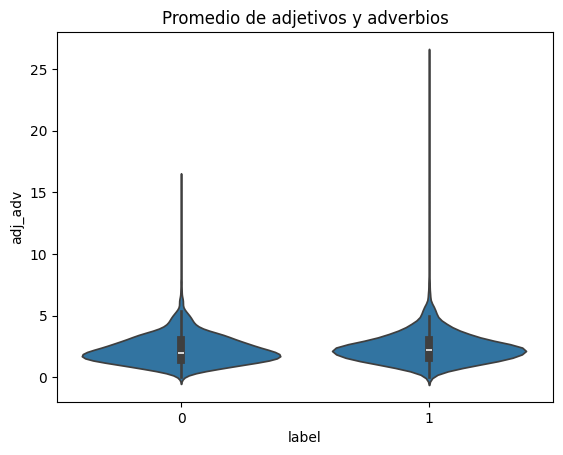

In [25]:
# Visualización de las distribuciones
ax= sns.violinplot(x='label', y="adj_adv", data=df)
ax.set_title('Promedio de adjetivos y adverbios')


In [26]:
# Test de Shapiro-Wilk para normalidad
stat, p = shapiro(df[df['label'] == 0]['adj_adv'])
print('Grupo No Estresado - estadísticas= %.3f, p=%.3f' % (stat, p))

stat, p = shapiro(df[df['label'] == 1]['adj_adv'])
print('Grupo Estresado - estadísticas= %.3f, p=%.3f' % (stat, p))

Grupo No Estresado - estadísticas= 0.904, p=0.000
Grupo Estresado - estadísticas= 0.779, p=0.000


In [27]:
u_stat, p_val = mannwhitneyu(df[df['label'] == 1]['adj_adv'],
                             df[df['label'] == 0]['adj_adv'])
print('Palabras: U=%.3f, p=%.3f' % (u_stat, p_val))

Palabras: U=1705033.500, p=0.000


In [28]:
u_stat, p_val = mannwhitneyu(df[df['label'] == 1]['adj_adv'],
                             df[df['label'] == 0]['adj_adv'], alternative="less")
print('Palabras: U=%.3f, p=%.3f' % (u_stat, p_val))

Palabras: U=1705033.500, p=1.000


La evaluación del uso de adjetivos y adverbios, como indicadores de la sintaxis y la estructura gramatical,revelóue mientras que el uso de adjetios y adverbios en diferente entre individuos estresados y no estresados, no es posible asumir que los individuos estresados utilizan una menor cantidad de adjetivos y adverbios. 

 no reveló diferencias significativas en el uso de estos elementos lingüísticos entre personas con y sin estrés. Este análisis sugiere que, en términos de la riqueza y complejidad del léxico utilizado (medido a través del promedio de adjetivos y adverbios por oración), el estrés no parece influir de manera determinante en las características sintácticas y gramaticales del lenguaje. Estos resultados destacan la posibilidad de que los efectos del estrés en la comunicación verbal sean más sutiles o se manifiesten principalmente en otros aspectos del lenguaje

#### **Frecuencia de Construcciones Pasivas**

In [29]:
docs = nlp.pipe(texts_sentence_sep)
df["passive_avg"] = [utils.average_passive_sentences(doc) for doc in docs]

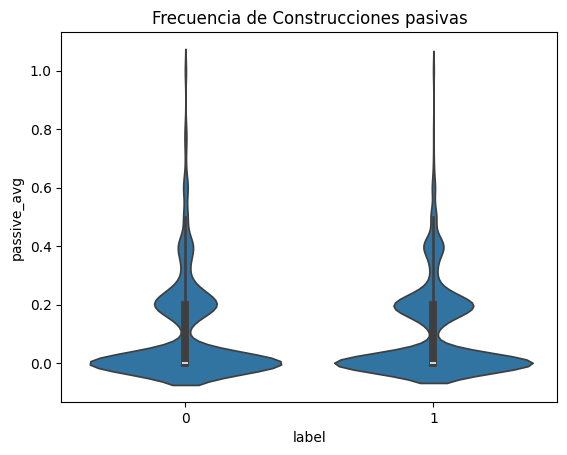

In [30]:
# Visualización de las distribuciones
ax= sns.violinplot(x='label', y="passive_avg", data=df)
ax.set_title('Frecuencia de Construcciones pasivas');

In [31]:
# Test de Shapiro-Wilk para normalidad
stat, p = shapiro(df[df['label'] == 0]["passive_avg"])
print('Grupo No Estresado - estadísticas= %.3f, p=%.3f' % (stat, p))

stat, p = shapiro(df[df['label'] == 1]["passive_avg"])
print('Grupo Estresado - estadísticas= %.3f, p=%.3f' % (stat, p))

Grupo No Estresado - estadísticas= 0.668, p=0.000
Grupo Estresado - estadísticas= 0.711, p=0.000


In [32]:
u_stat, p_val = mannwhitneyu(df[df['label'] == 1]["passive_avg"],
                             df[df['label'] == 0]["passive_avg"])
print('Palabras: U=%.3f, p=%.3f' % (u_stat, p_val))

Palabras: U=1615557.000, p=0.124


El uso de construcciones pasivas en el discurso de individuos estresados y no estresados no ha evidenciado diferencias significativas entre estos dos grupos. Este hallazgo sugiere que el estrés, al menos en el contexto de este estudio, no parece inducir cambios detectables en aspectos tan sutiles del lenguaje como son las estructuras pasivas. Esta constancia en el uso de la voz pasiva podría indicar que los impactos del estrés en las características lingüísticas son menos pronunciados en la estructura gramatical, o que requieren de análisis más profundos para ser revelados. 

In [33]:
#Se separan los datos en test y train
df_train, df_test= train_test_split(df, test_size=0.1, random_state=42)

In [34]:
#Se exportan los datos procesados  a la siguiente capa 'silver'
data_path = Path(os.getcwd()).parent / "data"
train_output_path = data_path / "silver" / "dreadditCleanTrain.csv"
test_output_path = data_path / "silver" / "dreadditCleanTest.csv"

df_train.to_csv(train_output_path)
df_test.to_csv(test_output_path)